In [6]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import feather
import plotly.express as px
import psutil
import libpysal as lp
import esda
import rasterio as rio
import contextily as ctx
import shapely.geometry as geom
import mapclassify as mc
from matplotlib import colors
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [2]:
# read afgifte feather 
df = pd.read_feather('../data/lma/af_2019-2020_valid.feather')
df = df[['eaPostcode', 'mat', 'matDesc', 'sbiSec', 'sbiSecDesc', 'kg']]
df.eaPostcode = df.eaPostcode.str[:4]
df.rename(columns={'eaPostcode': 'pc'}, inplace=True)

# read pc, add geometry
pc = gpd.read_file('../data/spatial-data/nl_pc4.shp')
pc = pc[['PC4', 'geometry']]
pc.rename(columns={'PC4': 'pc'}, inplace=True)
df = pd.merge(df, pc, on='pc', how='left')
df = gpd.GeoDataFrame(df)
df.head()

# weight matrix
wq =  lp.weights.Queen.from_dataframe(pc) # queen spatial weights - for each pc, identify neighbors (other pcs that share a vertex or edge)
wq.transform = 'r' # weights get row normalized, so when you sum the row, it equals 1

# make spatial weight matrix with no islands 
pcIslands = list(pc.iloc[wq.islands].pc) # identify island pcs
pc4ni = pc[~pc.pc.isin(pcIslands)]
wqni =  lp.weights.Queen.from_dataframe(pc4ni) 
wqni.transform = 'r'

C:\Users\tpytsui\Miniconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 2 islands with ids: 3478, 3611.
  warnings.warn(message)


('WARNING: ', 3478, ' is an island (no neighbors)')
('WARNING: ', 3611, ' is an island (no neighbors)')


C:\Users\tpytsui\Miniconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


In [3]:
def extract_top_weight(df, flowType, topn=10, plot=False):
    '''
    extracts top 10 flows according to material / industry
    df = afgifte dataset (containing only valid rows)
    flowType = mat for material, sbiSec for industry 
    returns dataframe of top 10 flows by weight (kg)
    '''
    
    # extract top 10
    dfCat = df.groupby(flowType).sum().reset_index()
    dfCatTop10 = dfCat[(dfCat[flowType] != '--') & (dfCat[flowType] != 'mul')].sort_values(by='kg', ascending=False).head(topn)
    kgMin = dfCatTop10.iloc[-1].kg
    
    # plot
    if plot == True: 
        dfCat.loc[dfCat['kg'] < kgMin, flowType] = 'Other {}'.format(flowType) # Represent only large sbis 
        fig = px.pie(dfCat, values='kg', names=flowType, title='kg received per {}'.format(flowType))
        fig.show()
    
    return dfCatTop10


def extract_top_geo(df, flowType, topn=10, plot=False): 
    '''
    extracts top 10 flows according to percentages of postcodes receiving this flow 
    df = afgifte dataset (containing only valid rows)
    flowType = mat for material, sbiSec for industry
    returns dataframe of top10 flow types by geographical spread (% postcodes receiving this flowType)
    '''

    # count num pc for each flowType
    flowTypes = []
    percPcs = []
    for i in df[flowType].unique(): 
        numPc = len(df[df[flowType].isin([i])].groupby('pc').sum())
        percPc = round(numPc / len(pc) * 100,1)
        percPcs.append(percPc)
        flowTypes.append(i)

    # make df of flowtypes and numPcs 
    df_percPcs = pd.DataFrame({
        '{}'.format(flowType): flowTypes, 
        'percPcs': percPcs
    })
    df_percPcs = df_percPcs.sort_values(by='percPcs', ascending=False)
    df_percPcs = df_percPcs[(df_percPcs[flowType] != '--') & (df_percPcs[flowType] != 'mul')]
    
    # plot
    if plot == True: 
        fig = px.bar(df_percPcs, x=flowType, y='percPcs')
        fig.show()
    
    return df_percPcs.head(topn)
    

def distplot_top10(dfTop10): 
    '''
    make distplot of top 10 flow types 
    dfTop10 = df of top 10 flow types, with type and kg 
    '''
    
    flowType = dfTop10.columns[0]
    nFlows = len(dfTop10)

    # make fig, ax
    fig, ax = plt.subplots(2,nFlows,figsize=(5*nFlows,5*2))

    # for each material: 
    for i, flow in enumerate(dfTop10[flowType]): 
        temp = df[df[flowType] == flow]
        temp = temp[temp.kg > 0]
        temp['log_kg'] = temp.kg.map(lambda x: np.log(x))
        sn.histplot(data=temp, x="kg", bins=30, ax=ax[0,i]) # distplot of normal values
        ax[0,i].set_title('# postcodes for {}'.format(flow))
        sn.histplot(data=temp, x="log_kg", bins=30, ax=ax[1,i]) # displot of log-transformed values 

    # show plt 
    plt.show()


def map_plot(dftop10): 
    '''
    maps of top 10 flows, along with % zero values 
    dftop10 = df of top 10 flows created with extract_top10_weight function 
    '''
    nFlows = len(dftop10)
    flowType = dftop10.columns[0]
    fig, ax = plt.subplots(1,nFlows,figsize=(5*nFlows,5*1))

    for i, v in enumerate(dftop10[flowType]): 
        temp = df[df[flowType] == v].groupby(['pc']).sum().reset_index()
        temp['log_kg'] = temp.kg.map(lambda x: np.log(x) if x > 0 else 0)
        temp = pd.merge(temp, pc, on='pc', how='right')
        temp.fillna(0, inplace=True)
        perc = 100 - round(len(temp[temp.kg > 0]) / len(temp) * 100, 2) 
        title = '{}, {}% zero'.format(v, perc)
        temp.plot(column='log_kg', cmap='OrRd', legend=True, ax=ax[i])
        ax[i].set_title(title)

    plt.show()

# calculate Moran's I of real and permeated values 
def calc_morans(dftop10, plot=False):
    '''
    dftop10 = df of top 10 flow types 
    returns df of observed, simulated, and p-value of Moran's I for top 10 flow types 
    '''
    nFlows = len(dftop10)
    flowType = dftop10.columns[0]
    mat_names = []
    mi_obs = []
    mi_sims_av = []
    mi_sims = []
    p_values = []
    miDict = {}

    for i in dftop10[flowType]: 
        # make temp df for flow type 
        temp = df[df[flowType] == i].groupby(['pc']).sum().reset_index()
        temp = pd.merge(temp, pc, on='pc', how='right')
        temp.fillna(0, inplace=True)
        temp['log_kg'] = temp.kg.map(lambda x: np.log(x) if x > 0 else 0)

        # calculate Moran's I 
        y = temp['log_kg']
        np.random.seed(12345)
        mi = esda.moran.Moran(y, wq)

        # return dataframe with observed Moran's I, average sim Moran's I, and p-value 
        mat_names.append(i)
        mi_obs.append(mi.I)
        mi_sims_av.append(mi.EI)
        mi_sims.append(mi.sim)
        p_values.append(mi.p_sim)

    miDf = pd.DataFrame({
        flowType: mat_names,
        'mi_obs': mi_obs, 
        'mi_sims_av': mi_sims_av, 
        'mi_sims': mi_sims,
        'p_values': p_values
    })
    
    if plot == True: 
        fig, ax = plt.subplots(1,nFlows, figsize=(5*nFlows, 5))
        def plotMi(row): 
            i = row.name
            sn.kdeplot(row.mi_sims, shade=True, ax=ax[i])
            ax[i].vlines(row.mi_obs, 0, 40, color='r')
            ax[i].vlines(row.mi_sims_av, 0, 40)
            ax[i].set_title("{} (p-value: {})".format(row[flowType], row.p_values))
        miDf.apply(lambda row: plotMi(row), axis=1)
        plt.show()
    
    return miDf 


def morans_plot(dftop10): 
    '''
    plots Moran's scatterplot for top 10 flow types 
    '''

    nFlows = len(dftop10)
    flowType = dftop10.columns[0]
    fig, ax = plt.subplots(1,nFlows, figsize=(8*nFlows, 8))

    for i,v in enumerate(dftop10.iloc[:,0]): 
        # temp df for flow type
        temp = df[df[flowType] == v]
        temp = temp.groupby('pc').sum().reset_index()
        temp = pd.merge(pc, temp, on='pc', how='left')
        temp.fillna(0, inplace=True)
        temp['log_kg'] = temp.kg.map(lambda x: np.log(x) if x > 0 else 0)

        # calculate spatial lag 
        y = temp.kg
        ylag = lp.weights.lag_spatial(wq, y)
        temp['lag_kg'] = ylag
        temp['log_lag_kg'] = temp.lag_kg.map(lambda x: np.log(x) if x > 0 else 0)

        # PLOT
        kg = temp['log_kg']
        lag_kg = temp['log_lag_kg'] # average kg_received of neighbors 

        # polynomial of degree 1, aka draw a straight line that best fits the datapoints, where b, a is (y = bx + a)
        b, a = np.polyfit(kg, lag_kg, 1) 

        # scatterplot of kg versus lagged kg
        ax[i].plot(kg, lag_kg, '.', color='lightblue')

        # red line of best fit using global I as slope
        ax[i].plot(kg, b*kg+a, 'r')
        ax[i].set_title('{}'.format('25'))
        ax[i].set_ylabel('Spatial Lag of log(kg)')
        ax[i].set_xlabel('log(kg)')

        # dashed lines at mean of the kg and lagged kg
        ax[i].vlines(kg.mean(), lag_kg.min(), lag_kg.max(), linestyle='--')
        ax[i].hlines(lag_kg.mean(), kg.min(), kg.max(), linestyle='--')

    plt.show()

def plot_hcdd(dftop10): 
    '''
    plot maps of hotspots, coldspots, doughnuts, and diamonds for top 10 flows 
    '''
    nFlows = len(dftop10)
    flowType = dftop10.columns[0]
    f, ax = plt.subplots(1,nFlows, figsize=(6*nFlows,8))
    hmap = colors.ListedColormap(['lightgrey', 'red', 'lightblue', 'blue', 'pink'])


    for i,v in enumerate(dftop10.iloc[:,0]):
        # temp df for flow type
        temp = df[df[flowType] == v]
        temp = temp.groupby('pc').sum().reset_index()
        temp = pd.merge(pc, temp, on='pc', how='left')
        temp.fillna(0, inplace=True)
        temp['log_kg'] = temp.kg.map(lambda x: np.log(x) if x > 0 else 0)
        temp = temp[~temp.pc.isin(pcIslands)]

        # local Moran's I
        y = temp.log_kg
        li = esda.moran.Moran_Local(y, wqni)
        n_sig = (li.p_sim < 0.05).sum()

        # values of hotspots, coldspots...etc.
        sig = 1 * (li.p_sim < 0.05)
        hotspot = 1 * (sig * li.q==1)
        coldspot = 3 * (sig * li.q==3)
        doughnut = 2 * (sig * li.q==2)
        diamond = 4 * (sig * li.q==4)
        spots = hotspot + coldspot + doughnut + diamond
        spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
        labels = [spot_labels[i] for i in spots]

        # plot 
        temp.assign(cl=labels).plot(column='cl', categorical=True, \
                k=2, cmap=hmap, linewidth=0.1, ax=ax[i], \
                edgecolor='white', legend=True, legend_kwds={'loc': 'lower left', 'bbox_to_anchor':(0.,0.,0.,0.)})
        ax[i].set_axis_off()
        ax[i].set_title(v)

    plt.show()

In [4]:
# extract_top_weight(df, flowType, topn=10, plot=False)
# extract_top_geo(df, flowType, topn=10, plot=False)
# distplot_top10(dfTop10)
# map_plot(dftop10)
# calc_morans(dftop10, plot=False)
# morans_plot(dftop10)
# plot_hcdd(dftop10)

## Comments on results
The cell below shows the Moran's I results for the top 10 materials by weight and by geographical spread. 'Geographical spread' is defined by the percentage of postcodes that receive this type of material. 

#### Difference between weight versus geographical spread; material vs industry categorization 
For material categorization, there isn't a big difference between top 10 materials by weight versus by geographical spread. The differences are: 
* 06.1 (metallic wastes) was higher-up in the ranking for weight than for geographical spread. This means that there are a lot of these materials received, but these receivers are concentrated in a few locations. 
* 07.2 (paper and cardboard) showed up in the top 10 materials by weight, but not for by geographical spread. Instead, 07.5 (wood wastes) took its place. This also probably means that, although there is a lot of kgs of paper and cardboard, it's only received by a few locations. On the other hand, there are less kgs of wood wastes, but they are more spread out geographically. 

For industry categorization, there seem to be more differences: 
* Sectors B (mining of materials) and D (Production, distribution and trade in electricity, natural gas, steam and cooled air) showed up in top 10 by weight, but were replaced by N (Rental of movable property and other business services) and I (Lodging, meal and beverage provision) for top 10 by geographical spread. 

#### Effect of zero values / geographical spread on Moran's I results
When looking at the top 10 materials by weight, we can see that the level of clustering is not entirely related to weight. For example, the fourth largest material type, 07.2 (paper and cardboard wastes), isn't significantly clustered. From this result, we might claim that cardboard receivers are randomly distributed through the Netherlands, and that their location doesn't follow any spatial patterns. However, this is not the full story. If we look at the top 10 materials by geographical spread, we can wee a clear pattern for all the plots. For the kde plots, we can see that, look from left to right, the red line gets closer to the blue curve. Looking at the Moran's scatter plots from left to right, we see that the red line gets flatter, and the blue dots get fewer and more scattered. As for the hcdd plots, the hotspots are much larger on the left than on the right. 

Clearly, the amount of 'spatial clustering' calculated from Moran's I is very much related to the number of zero values in the dataset. The more zero values a material has, the less likely it will be significantly spatially clustered. This makes sense, and can be illustrated with an extreme example. Say that material 'A' is only received by 2 postcodes out of ~4000. It would be very difficult to answer the question, 'how likely is material 'A' randomly distributed through space?' Even if the two postcodes were right next to each other, we can't confidently say that the locations of material 'A' is not random. On the other hand, let's say that material 'B' is received by all 4000 post codes, but some postcodes receive a lot while others receive less. If all the high values for material 'B' are next to each other, we can more confidently say that material 'B' is following a spatial pattern, because it's highly unlikely that 3000 postcodes arranged themselves in clusters randomly. 

## Limitations - what can and can't we conclude from the results? 
* difficult to say that material categorization is better than industry categorization
    * more flows in material than in industry, cannot compare. 
    * even if using the same flows, need to check if there are roughly the same amount of categorizations of material vs industry, and that each categorization has roughly same kg...?
* what global and local Moran's I says about spatial clustering / patterns 
    * cannot say industry 'A' is more clustered than industry 'B', because they have vastly different amounts of zero values. Can only say 'A' has less zero values than 'B'. Can also say that these flows follow spatial pattern and those flows don't? 
    * hotspots probably make sense for flows that have a higher geographical spread (and are significantly clustered) 
    * Moran's I values seem low (ranging from 0 to 0.26) compared to paper on gdp per capita, which has Moran's I values of 0.6 (Gallo and Ertur 2005). But other studies (Messner et al. 1999, Anselin et al. 2007) show lower Moran's I values, more similar to ours. 
* some industry categorizations don't really make sense - why is there mining? or distribution of energy? 

## Next steps 
* data cleaning / sorting
    * closer examination of flows - are categorization of material vs industry roughly the same? e.g. do top 3 industry and top 3 materials have roughly the same amount (kg)? Are there roughly the same number of categorizations for mat versus ind? 
    * aggregate data to 2-digit postcode (n=90) instead of 4-digit postcode (n=4000)? Will probably result in a lot less zero values. Other ESDA studies (Gallo and Ertur 2005, Messner et al. 1999, Anselin et al. 2007) have a lot less datapoints. Looking at the maps, looks no more than 100. We are currently doing 4000. Probably too much / too complicated? 
    * combine ESV and GNC? 
* method
    * binary Moran's I? 
    * different spatial weights (currently using queen weights, but can also use rook, nearest neighbors, distance...etc) See Anselin et al. 2007 for example 

In [37]:
pd.merge(dfMat, df.groupby(['mat', 'matDesc']).sum().reset_index(), on='mat', how='left')

mat        kg_x                                            matDesc  \
0    25  3173861633  GNC - SALT; SULPHUR; EARTHS AND STONE; PLASTER...   
1  12.8  1604378507   ESV - Mineral wastes: Waste from waste treatment   
2  12.1  1222254775  ESV - Mineral wastes: Construction and demolit...   
3  07.2   872272679  ESV - Non-metallic wastes: Paper and cardboard...   
4  12.6   854514125                        ESV - Mineral wastes: Soils   
5  06.1   643929732       ESV - Metallic wastes: Metal wastes, ferrous   
6    31   574860270                                  GNC - FERTILISERS   
7  09.2   523730036    ESV - Animal and vegetal wastes: Vegetal wastes   
8  10.3   416275554               ESV - Mixed wastes: Sorting residues   
9  06.2   324680435   ESV - Metallic wastes: Metal wastes, non-ferrous   

         kg_y  
0  3173861633  
1  1604378507  
2  1222254775  
3   872272679  
4   854514125  
5   643929732  
6   574860270  
7   523730036  
8   416275554  
9   324680435

In [40]:
pd.merge(dfInd_geo, df.groupby(['sbiSec', 'sbiSecDesc']).sum().reset_index(), on='sbiSec', how='left').loc[5,'sbiSecDesc']

'Winning en distributie van water; afval- en afvalwaterbeheer en sanering '

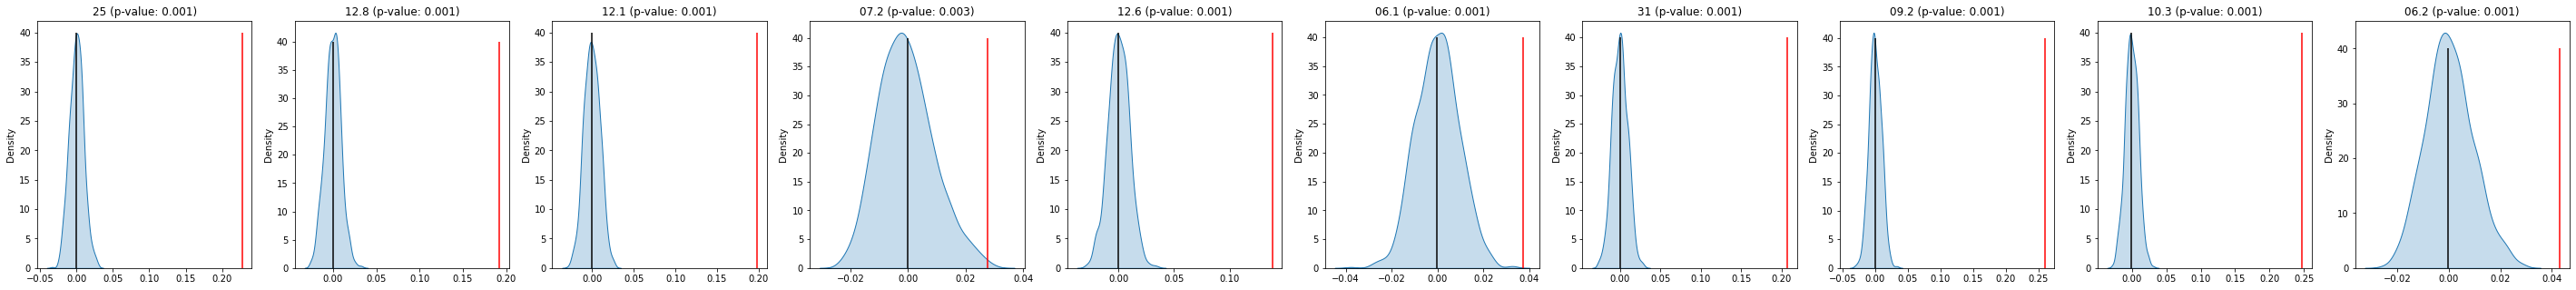

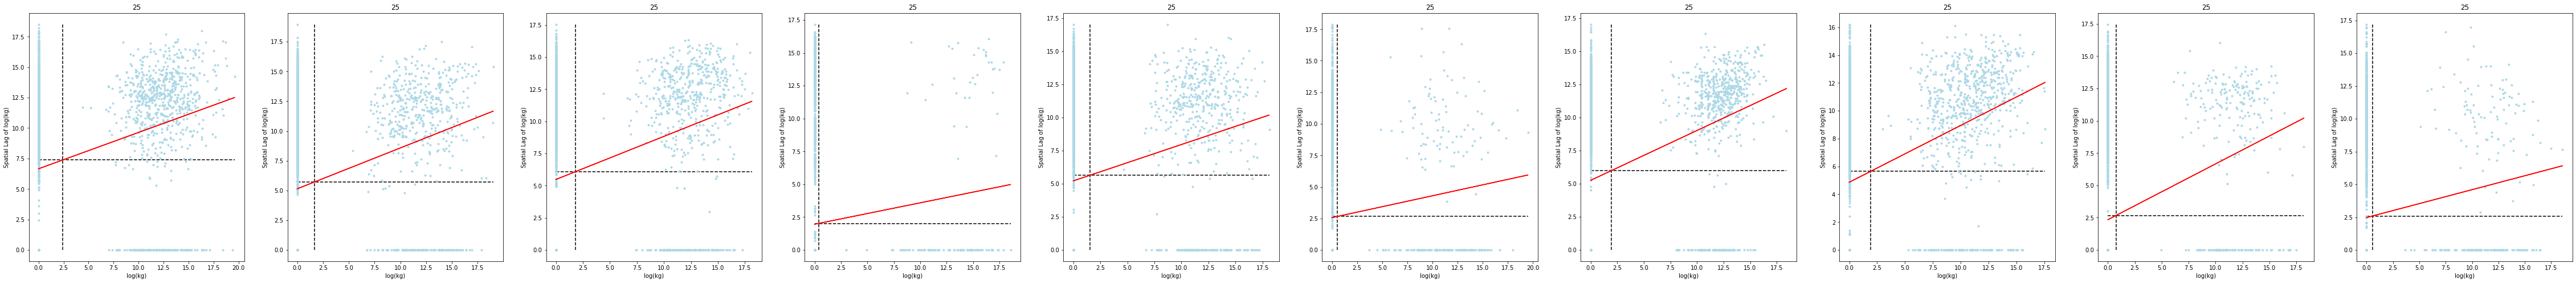

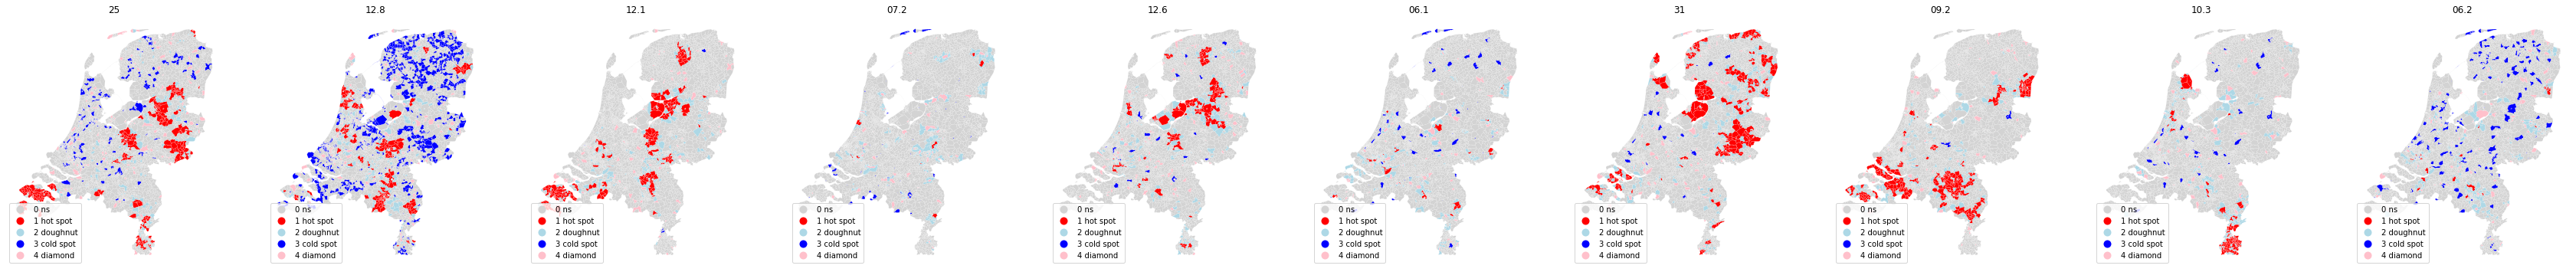

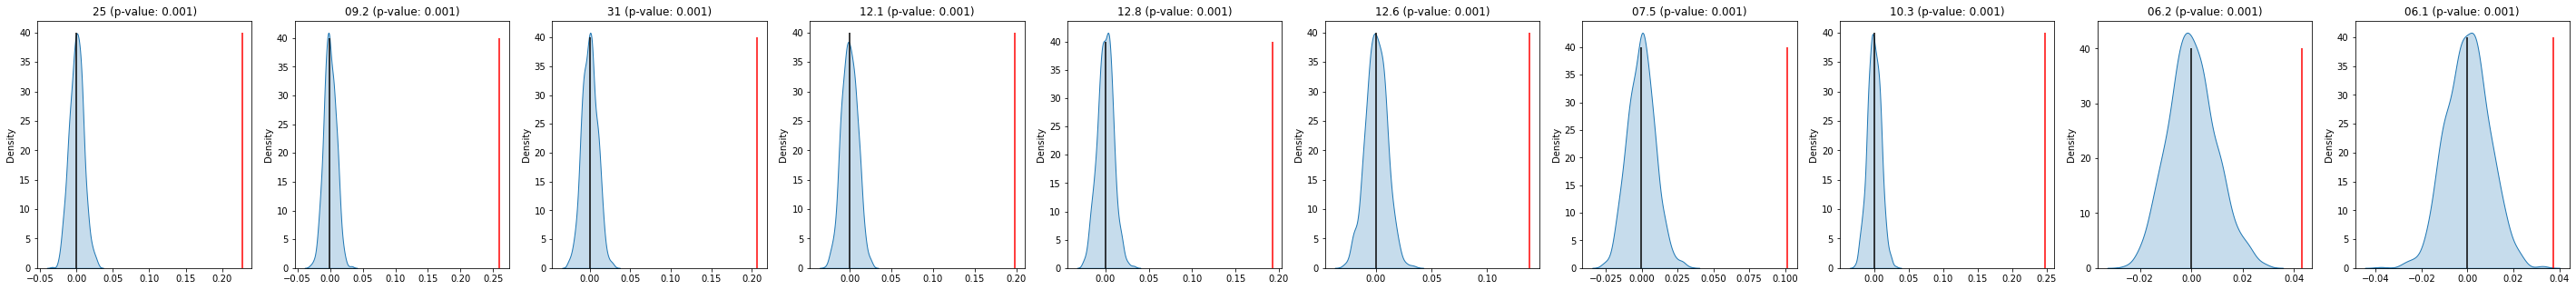

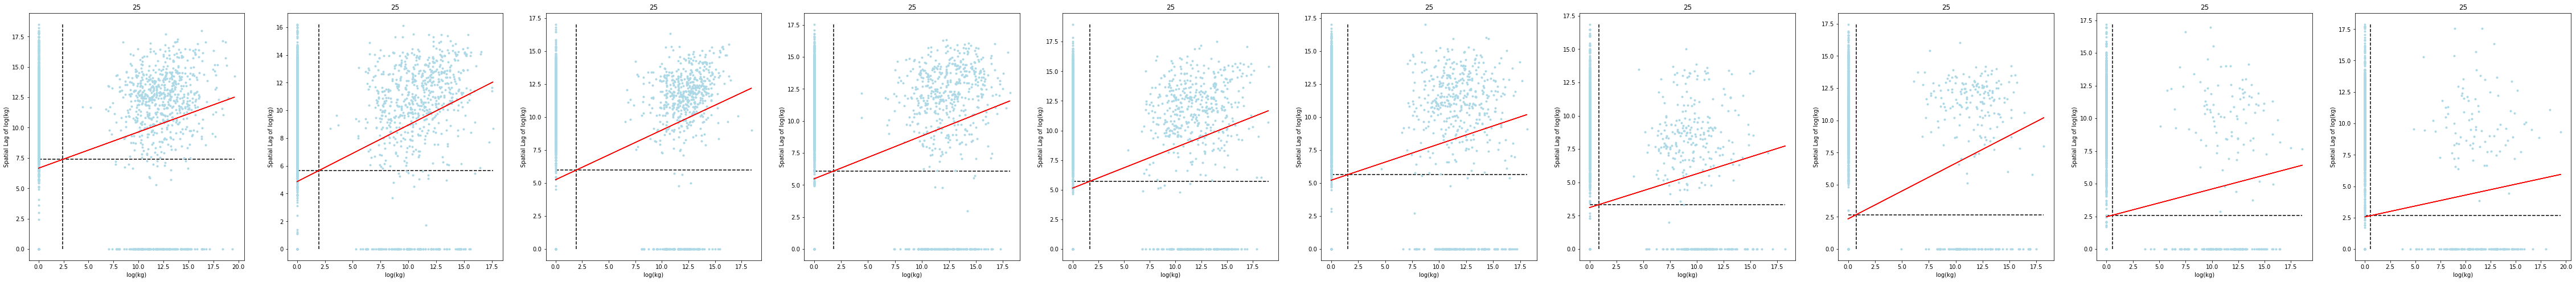

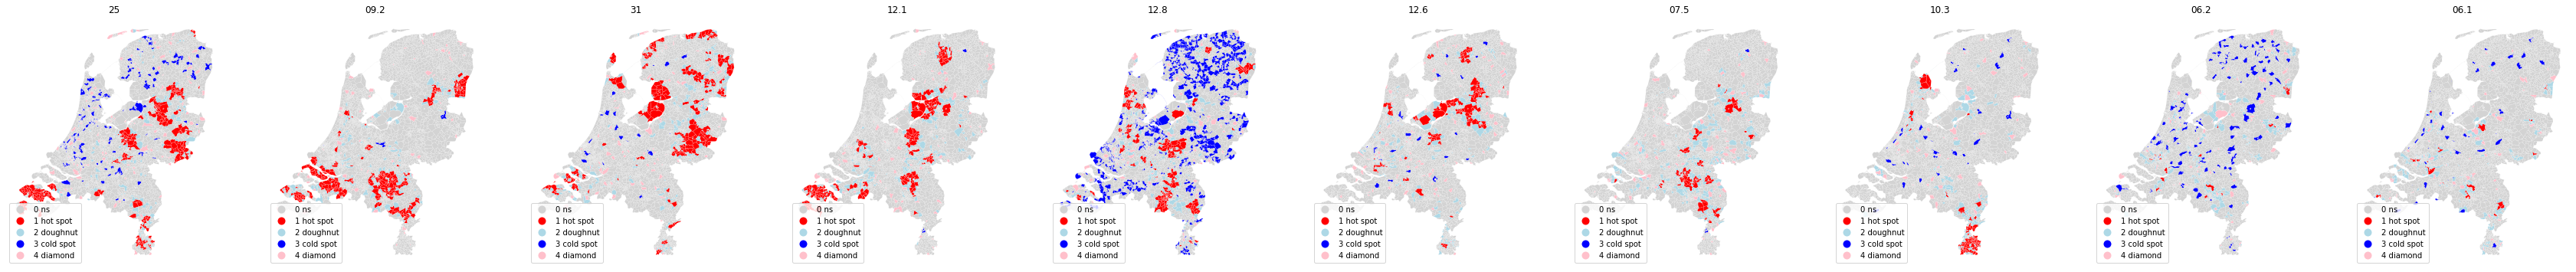

['07.2', '07.5']


In [7]:
dfMat = extract_top_weight(df, flowType='mat', topn=10, plot=False)
dfMatList = [i for i in dfMat.mat]
miDfMat = calc_morans(dfMat, plot=True)
morans_plot(dfMat)
plot_hcdd(dfMat)

dfMat_geo = extract_top_geo(df, flowType='mat', topn=10, plot=False)
dfMatList_geo = [i for i in dfMat_geo.mat]
miDfMat_geo = calc_morans(dfMat_geo, plot=True)
morans_plot(dfMat_geo)
plot_hcdd(dfMat_geo)

print(list(set(dfMatList) - set(dfMatList_geo)) + list(set(dfMatList_geo) - set(dfMatList)))

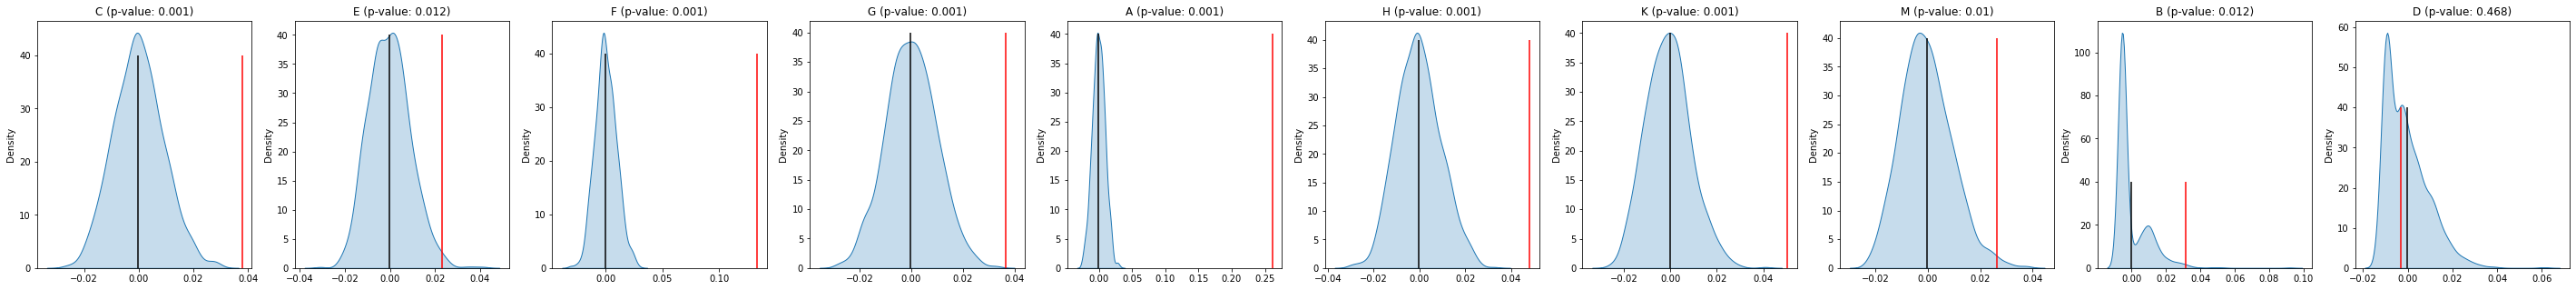

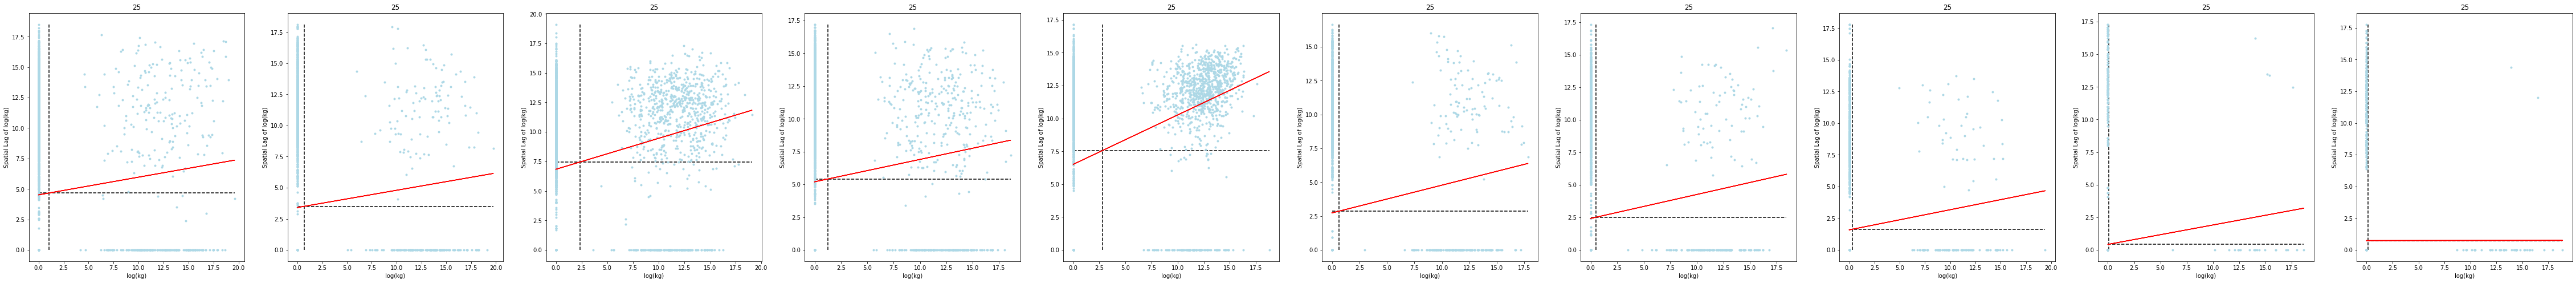

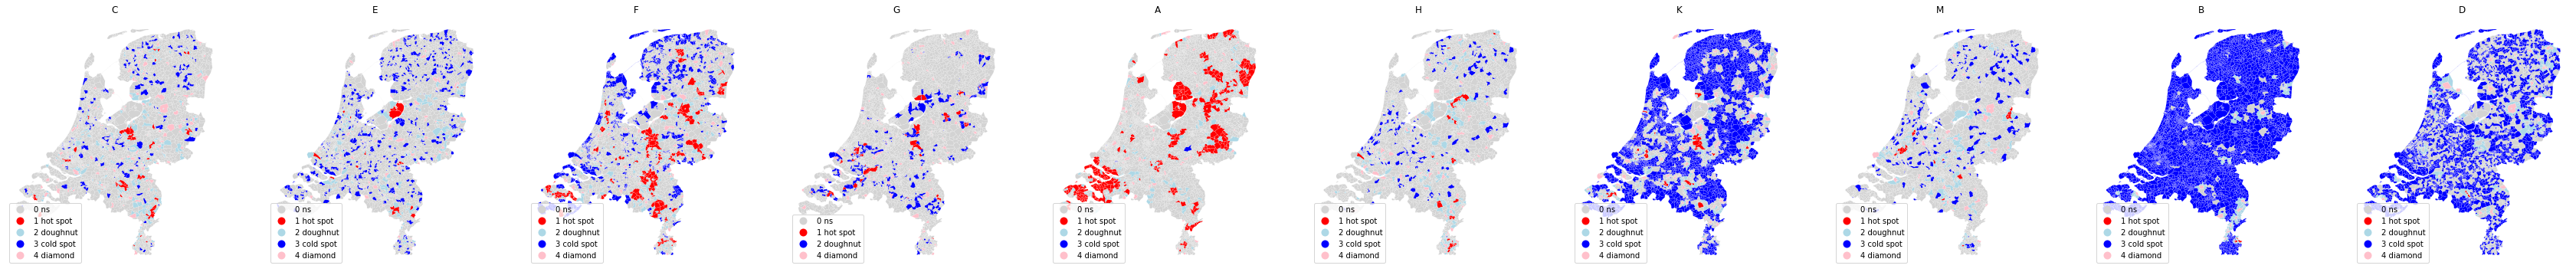

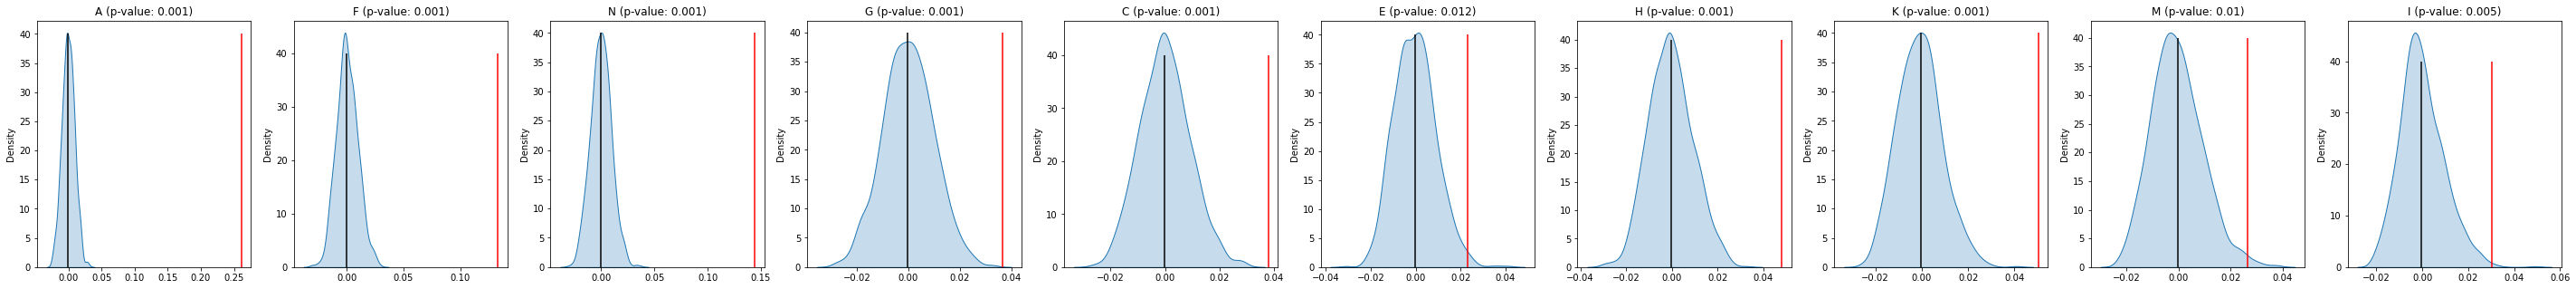

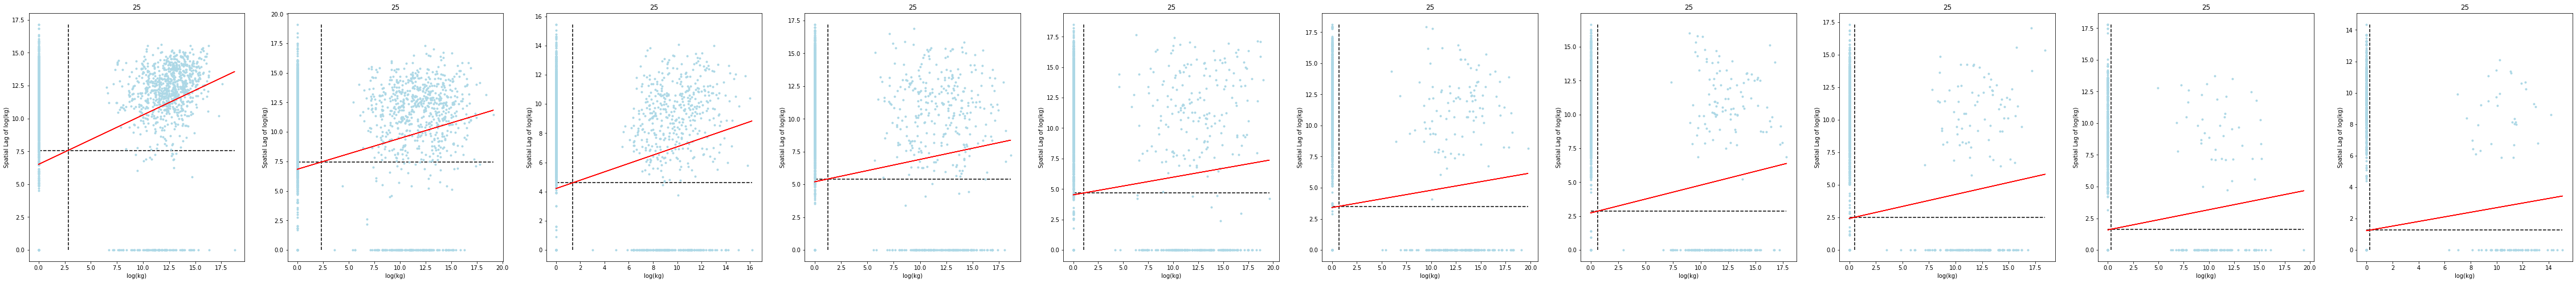

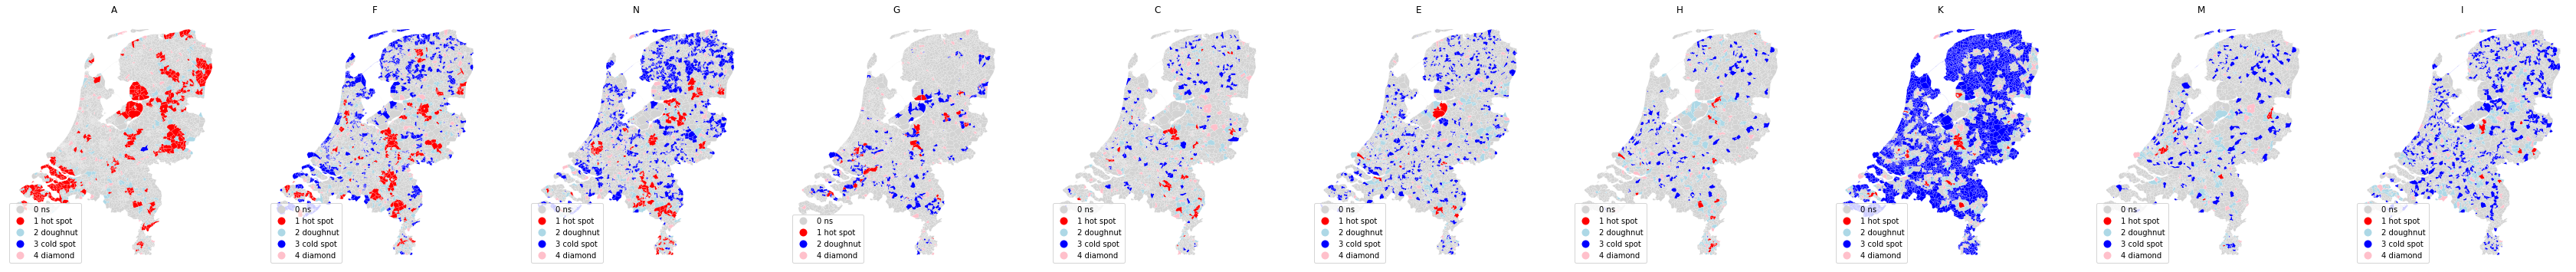

['B', 'D', 'N', 'I']


In [8]:
dfInd = extract_top_weight(df, flowType='sbiSec', topn=10, plot=False)
dfIndList = [i for i in dfInd.sbiSec]
miDfInd = calc_morans(dfInd, plot=True)
morans_plot(dfInd)
plot_hcdd(dfInd)

dfInd_geo = extract_top_geo(df, flowType='sbiSec', topn=10, plot=False)
dfIndList_geo = [i for i in dfInd_geo.sbiSec]
miDfInd_geo = calc_morans(dfInd_geo, plot=True)
morans_plot(dfInd_geo)
plot_hcdd(dfInd_geo)

print(list(set(dfIndList) - set(dfIndList_geo)) + list(set(dfIndList_geo) - set(dfIndList)))